In [ ]:
!pip install zstandard

In [1]:
#import files
import json
import zstandard as zstd
import tldextract
import numpy as np
import pandas as pd
import scipy.sparse
import shutil
import pickle
import time
from scipy.sparse import csr_matrix,coo_matrix
from pandas.api.types import CategoricalDtype
import random
from scipy.sparse.linalg import spsolve
import implicit
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import os
from sklearn.metrics import ndcg_score,dcg_score
os.environ['MKL_NUM_THREADS'] = '1' #To avoid multithreading.
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
#function to save large files
#change to protocol 0 for text output
def save_obj(obj, file_path_name):
    with open(file_path_name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(file_path_name):
    with open(file_path_name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Required Domain List

In [3]:
news_domain_df = pd.read_csv("/research/cbuntain/projects/recsys.trajectories/datafiles/fb_domain_ideology.csv", sep=",")
# shows top 10 rows
#print(news_domain_df.head(5))
news_domain_list = news_domain_df['domain'].tolist()

In [ ]:
#This function decompresses reddit .zst extention file

def decompress_zstandard_to_folder(input_file, output_name):
    with open(input_file, 'rb') as compressed:
        decomp = zstd.ZstdDecompressor()
        with open(output_name, 'wb') as destination:
            decomp.copy_stream(compressed, destination)

In [ ]:
decompress_zstandard_to_folder("/research/cbuntain/datasets/reddit/RS_2020-04.zst",
                              "/research/cbuntain/projects/recsys.trajectories/datafiles/Extracted_files/decompressed_reddit.txt")

In [ ]:
#For Testing
f = open('/research/cbuntain/projects/recsys.trajectories/datafiles/Extracted_files/decompressed_reddit.txt', 'r')
for i in range(5):
    print(f.readline())

## Build relations file

In [ ]:
 #This function build relations file for reddit decompressed data and extract required news domains using tldextract.

def build_relations_file(read_file, write_file):
    with open(write_file, 'w') as f:
        with open(read_file, 'rb') as fh:
            print('trying to read file')
            #iterates each line
            print('looping')
            start_time = time.perf_counter()
            num_unshortened_urls = 0
            for line in fh:
                try:
                    object = json.loads(line)
                    if not object['is_self']:
                        current_domain = tldextract.extract(object['url']).registered_domain.lower()
                        if current_domain in news_domain_list:
                            num_unshortened_urls += 1
                        f.write(current_domain + " " + object['subreddit'] + ' ' + object['subreddit_id'] + ' ' + object['author'] + '\n')
                except Exception as e:
                    print('read/loop error: ')
                    print(e)
    print('complete')
    print('time: ' , time.perf_counter()-start_time)
    print('unshortened ', num_unshortened_urls, ' urls')

In [ ]:

build_relations_file("/research/cbuntain/projects/recsys.trajectories/datafiles/Extracted_files/decompressed_reddit.txt","/research/cbuntain/projects/recsys.trajectories/datafiles/Extracted_files/relations_reddit.txt")

In [48]:
#For testing
f = open('/research/cbuntain/projects/recsys.trajectories/datafiles/Extracted_files/relations_reddit.txt', 'r')
for i in range(10):
    print(f.readline())

imgur.com desigentlemanboners t5_254apc shadilal_gharjode

redd.it muslimculture t5_12rumi Karlukoyre

redd.it Manatees t5_2stjo Bill_Hsomething

redd.it BillHsomething t5_3h8mf Bill_Hsomething

redd.it marshydrogrowers t5_252c8n marshydrogrow

xn--constanamea-ebe.ro gatech t5_2r8t2 robertacordovan

redd.it perfectlycutscreams t5_3n7fs Hikararu

redd.it aww t5_2qh1o Lilibunny

crunchyroll.com u_kfz716 t5_2jbk4y kfz716

twitter.com SubofJericho t5_3ib9d sunshine_enema



## Creating User-Domain Matrix

In [4]:
#Make reddit data dataframe from relations file
colnames=['Domain', 'Subreddit', 'Subreddit_id', 'Username']
reddit_df = pd.read_csv('/research/cbuntain/projects/recsys.trajectories/datafiles/Extracted_files/relations_reddit.txt', sep=" ",names = colnames)

In [5]:
print(len(reddit_df))
print(reddit_df.head(5))

17197609
      Domain            Subreddit Subreddit_id           Username
0  imgur.com  desigentlemanboners    t5_254apc  shadilal_gharjode
1    redd.it        muslimculture    t5_12rumi         Karlukoyre
2    redd.it             Manatees     t5_2stjo    Bill_Hsomething
3    redd.it       BillHsomething     t5_3h8mf    Bill_Hsomething
4    redd.it     marshydrogrowers    t5_252c8n      marshydrogrow


### Some basic check on reddit dataframe

In [6]:
#reddit_df = reddit_df.drop(columns=['Subreddit', 'Subreddit_id'])
reddit_df["domain_check"] = reddit_df['Domain'].isin(news_domain_list)

In [7]:
reddit_df.head(5)

,Domain,Subreddit,Subreddit_id,Username,domain_check
0,imgur.com,desigentlemanboners,t5_254apc,shadilal_gharjode,True
1,redd.it,muslimculture,t5_12rumi,Karlukoyre,True
2,redd.it,Manatees,t5_2stjo,Bill_Hsomething,True
3,redd.it,BillHsomething,t5_3h8mf,Bill_Hsomething,True
4,redd.it,marshydrogrowers,t5_252c8n,marshydrogrow,True


In [8]:
#This proves only required domains are used
reddit_df.domain_check.value_counts()

True     14213105
False     2984504
Name: domain_check, dtype: int64

In [9]:
reddit_df = reddit_df[reddit_df['domain_check'] == True]

In [10]:
reddit_df.domain_check.value_counts()

True    14213105
Name: domain_check, dtype: int64

In [11]:
print(len(reddit_df))

14213105


In [12]:
#reddit_df = reddit_df.drop_duplicates()
reddit_df = reddit_df.drop(columns=['domain_check'])
print(len(reddit_df))

14213105


In [4]:
print('Domain count:',len(reddit_df['Domain'].unique().tolist()))
print('Users count:',len(reddit_df['Username'].unique().tolist()))

Domain count: 1656
Users count: 2625773


In [49]:
reddit_df.head(5)

NameError: name 'reddit_df' is not defined

In [15]:
#save and load reddit dataframe original
save_obj(reddit_df,"/research/cbuntain/projects/recsys.trajectories/datafiles/Reddit dataframes/reddit_df")

In [50]:
reddit_df = load_obj("/research/cbuntain/projects/recsys.trajectories/datafiles/Reddit dataframes/reddit_df")


In [52]:
reddit_df= reddit_df.drop(columns=['Subreddit_id','Subreddit'])

In [53]:
reddit_df

,Domain,Username
0,imgur.com,shadilal_gharjode
1,redd.it,Karlukoyre
2,redd.it,Bill_Hsomething
3,redd.it,Bill_Hsomething
4,redd.it,marshydrogrow
...,...,...
17197603,youtube.com,michae1mlke
17197604,youtube.com,PeggyAnnMcKay
17197606,youtube.com,[deleted]
17197607,redd.it,Wolfbeast5672


In [54]:
len(reddit_df)

14213105

In [15]:
#counts no of domains shared by each user
reddit_count_df = reddit_df.groupby(["Username", "Domain"]).size().reset_index(name="Value")
print(reddit_count_df.tail(5))

                     Username        Domain  Value
2958218           zzzzzzzztuo  facebook.com      1
2958219           zzzzzzzztuo       redd.it      1
2958220  zzzzzzzzzzzzccccccgg       redd.it      4
2958221  zzzzzzzzzzzzccccccgg    reddit.com      5
2958222  zzzzzzzzzzzzvzzzzvzz       redd.it      1


In [16]:
reddit_count_df.shape

(2958223, 3)

In [17]:
#save and load reddit dataframe
save_obj(reddit_count_df,"/research/cbuntain/projects/recsys.trajectories/datafiles/Reddit dataframes/reddit_count_df")

In [3]:
reddit_count_df = load_obj("/research/cbuntain/projects/recsys.trajectories/datafiles/Reddit dataframes/reddit_count_df")

In [4]:
len(reddit_count_df)

2958223

In [8]:
print('Domain count:',len(reddit_count_df['Domain'].unique().tolist()))
print('Users count:',len(reddit_count_df['Username'].unique().tolist()))

Domain count: 1656
Users count: 2625773


In [ ]:
#check memory of dataframe

print(reddit_count_df.memory_usage(deep=True)) 

BYTES_TO_MB_DIV = 0.000001
def print_memory_usage_of_data_frame(df):
    mem = round(df.memory_usage().sum() * BYTES_TO_MB_DIV, 3) 
    print("Memory usage is " + str(mem) + " MB")
    
print_memory_usage_of_data_frame(reddit_count_df)

## Create sparse matrix and dataframe

In [5]:
def create_sparse_matrix_dataframe(df):
    Username_c = CategoricalDtype(sorted(df.Username.unique()), ordered=True)
    Domain_c = CategoricalDtype(sorted(df.Domain.unique()), ordered=True)
    row = df.Username.astype(Username_c).cat.codes
    col = df.Domain.astype(Domain_c).cat.codes
    sparse_matrix = csr_matrix((df["Value"], (row, col)), \
                           shape=(Username_c.categories.size, Domain_c.categories.size))
    sdf = pd.DataFrame.sparse.from_spmatrix(sparse_matrix,index=Username_c.categories,
                         columns=Domain_c.categories,)
    return sparse_matrix, sdf

In [6]:
#sdf-->sparse dataframe
sparse_matrix , sdf = create_sparse_matrix_dataframe(reddit_count_df)

In [7]:
sparse_matrix

<2625773x1656 sparse matrix of type '<class 'numpy.longlong'>'
	with 2958223 stored elements in Compressed Sparse Row format>

In [8]:
sdf

,100percentfedup.com,1011now.com,10best.com,10news.com,10tv.com,11alive.com,12news.com,12newsnow.com,12up.com,13abc.com,...,yaleclimateconnections.org,yellowhammernews.com,yesmagazine.org,youngliving.com,yourcentralvalley.com,youredm.com,youtube.com,zerohedge.com,zimbio.com,zinnedproject.org
*polhold00648,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
------------------GL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
----------------oops,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-------------EEE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-------------deleted,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzzzzzz21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zzzzzzzzab,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zzzzzzzztuo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zzzzzzzzzzzzccccccgg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#drop reddit columns from the data 
list_of_cols_to_drop = ['redd.it','reddit.com']
sdf_drop = sdf.drop(list_of_cols_to_drop, axis=1)
#sdf_drop is sparse dataframe with no reddit.com and redd.it

In [10]:
sdf_drop.shape

(2625773, 1654)

In [11]:
#calculate sparsity function

def sparcity_value(df):
    matrix_size = df.shape[0]*df.shape[1] # Number of possible interactions in the matrix
    num_domains = len(df.nonzero()[0]) # Number of domains interacted with
    sparsity = 100*(1 - (num_domains/matrix_size))
    print("Sparsity of Matrix :" + str(sparsity))
    
sparcity_value(sparse_matrix) 

Sparsity of Matrix :99.93196797492038


## Filtering the sparse dataframe with no of links shared by each user

In [12]:
#count total link shared by each user
shared_links_count  = reddit_count_df.groupby('Username')['Value'].agg("sum")
shared_links_count

Username
*polhold00648           1
------------------GL    1
----------------oops    1
-------------EEE        1
-------------deleted    1
                       ..
zzzzzzz21               2
zzzzzzzzab              1
zzzzzzzztuo             2
zzzzzzzzzzzzccccccgg    9
zzzzzzzzzzzzvzzzzvzz    1
Name: Value, Length: 2625773, dtype: int64

In [15]:
#filter the sdf(sparse dataframe) by no of links shared 
#sdf_k : k represents no of links shared more than k

sdf_1 = sdf.loc[shared_links_count[shared_links_count > 1].index,:] #only to check decrease no of users
sdf_5 = sdf.loc[shared_links_count[shared_links_count > 5].index,:]
sdf_10 = sdf.loc[shared_links_count[shared_links_count > 10].index,:]
sdf_15 = sdf.loc[shared_links_count[shared_links_count > 15].index,:]
sdf_20 = sdf.loc[shared_links_count[shared_links_count > 20].index,:]
sdf_25 = sdf.loc[shared_links_count[shared_links_count > 25].index,:]

In [13]:
sdf_drop_1 = sdf_drop.loc[shared_links_count[shared_links_count > 1].index,:] #only to check decrease no of users
sdf_drop_5 = sdf_drop.loc[shared_links_count[shared_links_count > 5].index,:]
sdf_drop_10 = sdf_drop.loc[shared_links_count[shared_links_count > 10].index,:]
sdf_drop_15 = sdf_drop.loc[shared_links_count[shared_links_count > 15].index,:]
sdf_drop_20 = sdf_drop.loc[shared_links_count[shared_links_count > 20].index,:]
sdf_drop_25 = sdf_drop.loc[shared_links_count[shared_links_count > 25].index,:]

In [16]:
print("Shape of more than 1 link shared User-Domain dataframe : ",sdf_1.shape)
print("Shape of more than 5 links shared User-Domain dataframe : ",sdf_5.shape)
print("Shape of more than 10 links shared User-Domain dataframe : ",sdf_10.shape)
print("Shape of more than 15 links shared User-Domain dataframe : ",sdf_15.shape)
print("Shape of more than 20 links shared User-Domain dataframe : ",sdf_20.shape)
print("Shape of more than 25 links shared User-Domain dataframe : ",sdf_25.shape)

Shape of more than 1 link shared User-Domain dataframe :  (1279215, 1656)
Shape of more than 5 links shared User-Domain dataframe :  (329921, 1656)
Shape of more than 10 links shared User-Domain dataframe :  (147036, 1656)
Shape of more than 15 links shared User-Domain dataframe :  (87849, 1656)
Shape of more than 20 links shared User-Domain dataframe :  (60171, 1656)
Shape of more than 25 links shared User-Domain dataframe :  (44786, 1656)


In [14]:
print("Shape of more than 1 link shared User-Domain dataframe : ",sdf_drop_1.shape)
print("Shape of more than 5 links shared User-Domain dataframe : ",sdf_drop_5.shape)
print("Shape of more than 10 links shared User-Domain dataframe : ",sdf_drop_10.shape)
print("Shape of more than 15 links shared User-Domain dataframe : ",sdf_drop_15.shape)
print("Shape of more than 20 links shared User-Domain dataframe : ",sdf_drop_20.shape)
print("Shape of more than 25 links shared User-Domain dataframe : ",sdf_drop_25.shape)

Shape of more than 1 link shared User-Domain dataframe :  (1279215, 1654)
Shape of more than 5 links shared User-Domain dataframe :  (329921, 1654)
Shape of more than 10 links shared User-Domain dataframe :  (147036, 1654)
Shape of more than 15 links shared User-Domain dataframe :  (87849, 1654)
Shape of more than 20 links shared User-Domain dataframe :  (60171, 1654)
Shape of more than 25 links shared User-Domain dataframe :  (44786, 1654)


### Convert different sdf(sparse dataframes) into sparse matrices sp

In [15]:
# Sparse matrix creation for filtered sparse dataframe

sp5 = scipy.sparse.csr_matrix(sdf_drop_5.values)
sp10 = scipy.sparse.csr_matrix(sdf_drop_10.values)
sp15 = scipy.sparse.csr_matrix(sdf_drop_15.values)
sp20 = scipy.sparse.csr_matrix(sdf_drop_20.values)
sp25 = scipy.sparse.csr_matrix(sdf_drop_25.values)

In [16]:
file= "/research/cbuntain/projects/recsys.trajectories/datafiles/Reddit dataframes/"

#the saved sparse matrices are the ones which donot have twitter.com as a domain

#save sparse matrix
scipy.sparse.save_npz(file+"sp5.npz", sp5, compressed=False)
scipy.sparse.save_npz(file+"sp10.npz", sp10, compressed=False)
scipy.sparse.save_npz(file+"sp15.npz", sp15, compressed=False)
scipy.sparse.save_npz(file+"sp20.npz", sp20, compressed=False)
scipy.sparse.save_npz(file+"sp25.npz", sp25, compressed=False)

In [17]:
#loads sparse matrix
# sp5 = scipy.sparse.load_npz(file+"sp5.npz")
# sp10 = scipy.sparse.load_npz(file+"sp10.npz")
# sp15 = scipy.sparse.load_npz(file+"sp15.npz")
sp20 = scipy.sparse.load_npz(file+"sp20.npz")
sp25 = scipy.sparse.load_npz(file+"sp25.npz")

In [18]:
#check sparcity

print("sparcity values")

print("Sparcity for sp5")
sparcity_value(sp5)
print("Sparcity for sp10")
sparcity_value(sp10)
print("Sparcity for sp15")
sparcity_value(sp15)
print("Sparcity for sp20")
sparcity_value(sp20)
print("Sparcity for sp25")
sparcity_value(sp25)

sparcity values
Sparcity for sp5
Sparsity of Matrix :99.95852566911267
Sparcity for sp10
Sparsity of Matrix :99.93501003447633
Sparcity for sp15
Sparsity of Matrix :99.91256983047599
Sparcity for sp20
Sparsity of Matrix :99.89099486455541
Sparcity for sp25
Sparsity of Matrix :99.870911032992


## Code to implement recommendation system¶

### Split data into train/test

In [ ]:
'''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''

In [19]:
def make_train(ratings, pct_test):
   
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user ro

In [20]:
#split train/test data for different sp sparse matrix
#masking percentage = 20%

# train_sp5, test_sp5, item_users_altered_sp5 = make_train(sp5, pct_test = 0.2)
# train_sp10, test_sp10, item_users_altered_sp10 = make_train(sp10, pct_test = 0.2)
# train_sp15, test_sp15, item_users_altered_sp15 = make_train(sp15, pct_test = 0.2)
train_sp20, test_sp20, item_users_altered_sp20 = make_train(sp20, pct_test = 0.2)
train_sp25, test_sp25, item_users_altered_sp25 = make_train(sp25, pct_test = 0.2)

### Fit ALS model

In [21]:
#this function runs als model 

def train_model(train_dataset):
    alpha=15
    domain_user_data = (train_dataset*alpha).astype('double')
    model = implicit.als.AlternatingLeastSquares(factors=20, regularization = 0.1, iterations = 50)
    model.fit(domain_user_data.T)
    user_vecs = model.user_factors
    item_vecs = model.item_factors
    return domain_user_data,model,user_vecs,item_vecs

In [22]:
# domain_user_data_sp5, model_sp5, user_vecs_sp5, item_vecs_sp5  = train_model(train_sp5)
# domain_user_data_sp10, model_sp10, user_vecs_sp10, item_vecs_sp10  = train_model(train_sp10)
# domain_user_data_sp15, model_sp15, user_vecs_sp15, item_vecs_sp15  = train_model(train_sp15)
domain_user_data_sp20, model_sp20, user_vecs_sp20, item_vecs_sp20  = train_model(train_sp20)
domain_user_data_sp25, model_sp25, user_vecs_sp25, item_vecs_sp25  = train_model(train_sp25)

## Evaluation Metrics

In [79]:
def auc_score(predictions, test):
   
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

In [80]:
def calc_auc_ndcg(training_set, altered_users, predictions, test_set):
    
    start_time = time.perf_counter()
    
    # create empty lists to store AUC/NDCG for each user that had an item removed from the training set and popularity auc/ndcg
    store_auc,popularity_auc,store_ndcg1,store_ndcg2,store_ndcg3,store_ndcg5,store_ndcg10,popularity_ndcg = ([] for i in range(8))
    
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        
        #auc calculation
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and domain
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
        
        #ndcg calculation
        store_ndcg1.append(ndcg_score([actual],[pred],k = 1)) # Calculate NDCG@1 for the given user and domain
        store_ndcg2.append(ndcg_score([actual],[pred],k = 2)) # Calculate NDCG@2 for the given user and domain
        store_ndcg3.append(ndcg_score([actual],[pred],k = 3)) # Calculate NDCG@3 for the given user and domain
        store_ndcg5.append(ndcg_score([actual],[pred],k = 5)) # Calculate NDCG@4 for the given user and domain
        store_ndcg10.append(ndcg_score([actual],[pred],k = 10)) # Calculate NDCG@10 for the given user and domain
        popularity_ndcg.append(ndcg_score([actual],[pop],k = 10)) # Calculate NDCG@10 using most popular domains
        
    # End users iteration
   
    print('time: ' , time.perf_counter()-start_time)
    
    return float('%.3f'%np.mean(store_auc)),float('%.3f'%np.mean(popularity_auc)),float('%.3f'%np.mean(store_ndcg1)),float('%.3f'%np.mean(store_ndcg2)),float('%.3f'%np.mean(store_ndcg3)),float('%.3f'%np.mean(store_ndcg5)),float('%.3f'%np.mean(store_ndcg10)),float('%.3f'%np.mean(popularity_ndcg))
   
 # Return the mean AUC/NDCG rounded to three decimal places for both test and popularity benchmark

In [81]:
print("AUC/NDCG for sp5 model")
scores_sp5=calc_auc_ndcg(train_sp5, 
              item_users_altered_sp5, 
              [scipy.sparse.csr_matrix(user_vecs_sp5), scipy.sparse.csr_matrix(item_vecs_sp5.T)], 
              test_sp5)
print(scores_sp5)

print("AUC/NDCG for sp10 model")
scores_sp10=calc_auc_ndcg(train_sp10, 
              item_users_altered_sp10, 
              [scipy.sparse.csr_matrix(user_vecs_sp10), scipy.sparse.csr_matrix(item_vecs_sp10.T)], 
              test_sp10)
print(scores_sp10)

print("AUC/NDCG for sp15 model")
scores_sp15=calc_auc_ndcg(train_sp15, 
              item_users_altered_sp15, 
              [scipy.sparse.csr_matrix(user_vecs_sp15), scipy.sparse.csr_matrix(item_vecs_sp15.T)], 
              test_sp15)
print(scores_sp15)

print("AUC/NDCG for sp20 model")
scores_sp20=calc_auc_ndcg(train_sp20, 
              item_users_altered_sp20, 
              [scipy.sparse.csr_matrix(user_vecs_sp20), scipy.sparse.csr_matrix(item_vecs_sp20.T)], 
              test_sp20)
print(scores_sp20)

print("AUC/NDCG for sp25 model")
scores_sp25=calc_auc_ndcg(train_sp25, 
              item_users_altered_sp25, 
              [scipy.sparse.csr_matrix(user_vecs_sp25), scipy.sparse.csr_matrix(item_vecs_sp25.T)], 
              test_sp25)
print(scores_sp25)

AUC/NDCG for sp5 model
time:  227.3452535495162
(0.677, 0.974, 0.09, 0.1, 0.128, 0.137, 0.149, 0.537)
AUC/NDCG for sp10 model
time:  137.557955250144
(0.579, 0.972, 0.048, 0.06, 0.067, 0.076, 0.091, 0.526)
AUC/NDCG for sp15 model
time:  98.41729881614447
(0.744, 0.969, 0.194, 0.212, 0.22, 0.23, 0.247, 0.516)
AUC/NDCG for sp20 model
time:  77.77457190304995
(0.756, 0.968, 0.231, 0.24, 0.249, 0.26, 0.275, 0.536)
AUC/NDCG for sp25 model
time:  62.897892728447914
(0.771, 0.966, 0.254, 0.265, 0.276, 0.288, 0.305, 0.539)


## Metrices Dataframe

In [82]:
scores_list = [scores_sp5,
              scores_sp10,
              scores_sp15,
              scores_sp20,
              scores_sp25]
cols = ['AUC_Prediction','AUC_Popular','NDCG@1','NDCG@2','NDCG@3','NDCG@5','NDCG@10','NDCG@10 Popular Baseline']
metrices_df = pd.DataFrame(scores_list, columns=cols)
metrices_df['SP Model']=['SP5','SP10','SP15','SP20','SP25']
metrices_df['SP Shape']=[sdf_5.shape,sdf_10.shape,sdf_15.shape,sdf_20.shape,sdf_25.shape]


In [83]:
metrices_df

,AUC_Prediction,AUC_Popular,NDCG@1,NDCG@2,NDCG@3,NDCG@5,NDCG@10,NDCG@10 Popular Baseline,SP Model,SP Shape
0,0.677,0.974,0.090,0.100,0.128,0.137,0.149,0.537,SP5,"(329921, 1656)"
1,0.579,0.972,0.048,0.060,0.067,0.076,0.091,0.526,SP10,"(147036, 1656)"
2,0.744,0.969,0.194,0.212,0.220,0.230,0.247,0.516,SP15,"(87849, 1656)"
3,0.756,0.968,0.231,0.240,0.249,0.260,0.275,0.536,SP20,"(60171, 1656)"
4,0.771,0.966,0.254,0.265,0.276,0.288,0.305,0.539,SP25,"(44786, 1656)"


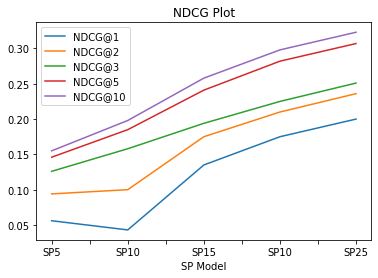

In [28]:
import matplotlib.pyplot as plt

# gca stands for 'get current axis'
ax = plt.gca()
ax.set_title("NDCG Plot")
metrices_df.plot(kind='line',x='SP Model',y=['NDCG@1','NDCG@2','NDCG@3','NDCG@5','NDCG@10'],ax=ax)
plt.show()

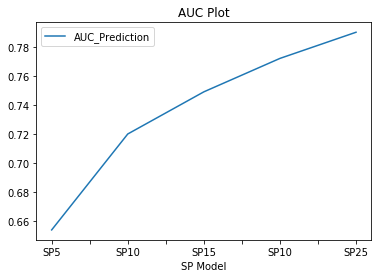

In [29]:
ax = plt.gca()
ax.set_title("AUC Plot")
metrices_df.plot(kind='line',x='SP Model',y=['AUC_Prediction'],ax=ax)
plt.show()

## Recommendations

In [23]:
item_lookup = reddit_count_df[['Domain']].drop_duplicates() # Only get unique item/description pairs
item_lookup['Domain'] = item_lookup.Domain.astype(str)

In [25]:
#using sp model 25

username_arr = np.array(list(np.sort(sdf_drop_25.index.unique())))
domain_arr = np.array(list(np.sort(sdf_drop_25.columns.unique())))

In [26]:
username_arr

array(['---DarkValkyrie---', '---HyDrA---', '---TommyBoy---', ...,
       'zzz1237', 'zzz500', 'zzztremelo'], dtype='<U20')

In [27]:
domain_arr

array(['100percentfedup.com', '1011now.com', '10best.com', ...,
       'zerohedge.com', 'zimbio.com', 'zinnedproject.org'], dtype='<U30')

In [28]:
def get_domains_viewed(customer_id, dataset,customers_list, domain_list,item_lookup):
    
    '''
    dataset: either train or test dataset 
    '''
    
    cust_ind = np.where(customers_list == customer_id)[0][0] # Returns the index row of our customer id
    
    domain_ind = dataset[cust_ind,:].nonzero()[1]# Get column indices of viewed domains
    print(domain_ind)
    domain_codes = domain_list[domain_ind] # Get the index for viewed domains
    return item_lookup.loc[item_lookup.Domain.isin(domain_codes)]

In [29]:
get_domains_viewed('-AintThatJustTheWay-', train_sp25, username_arr, domain_arr, item_lookup)

[470 888]


,Domain
876,nationalreview.com
994,foxnews.com


### Two ways used to generate the recpmmendations

### Method 1: Directly using the implicit library function model.recommend¶

In [31]:
def generate_recommendations(user_id,model,domain_user_data,spd,num_items):
    '''
    model: ALS model
    spd: sparse dataframe
    
    '''
    
    cust_ind = np.where((np.array(list(np.sort(spd.index.unique())))) == user_id)[0][0] # Returns the index row of our customer id
    
    #Recommendations
    recommended = model.recommend(cust_ind, domain_user_data.T)
    
    domains = []
    scores = []

    # Get artist names from ids
    for item in recommended:
        idx, score = item

        domains.append(spd.columns[idx])
        scores.append(score)

    # Create a dataframe of artist names and scores
    recommendations = pd.DataFrame({'Domain': domains, 'score': scores})
    return recommendations


In [33]:
generate_recommendations("-AintThatJustTheWay-",model_sp25,domain_user_data_sp25,sdf_drop_25,10)


,Domain,score
0,foxnews.com,0.484736
1,wikipedia.org,0.420520
2,nationalreview.com,0.367121
3,washingtontimes.com,0.366544
4,washingtonexaminer.com,0.341690
5,nypost.com,0.304703
6,breitbart.com,0.299655
7,dailycaller.com,0.298774
8,zerohedge.com,0.289845
9,dailywire.com,0.287073


### Method 2: User defined way to calculate --> To get the actual score we take the dot product between the trained user vector and the transpose of the item vectors.¶

In [34]:
def rec_items(customer_id, mf_train, user_vecs, item_vecs, customer_list, item_list, num_items = 10):
 
    
    '''
    This function will return the top recommended items to our users 
    
    parameters:
    
    customer_id - Input the customer's id number that you want to get recommendations for
    
    mf_train - The training matrix you used for matrix factorization fitting
    
    user_vecs - the user vectors from your fitted matrix factorization
    
    item_vecs - the item vectors from your fitted matrix factorization
    
    customer_list - an array of the customer's ID numbers that make up the rows of your ratings matrix 
                    (in order of matrix)
    
    item_list - an array of the domains that make up the columns of your ratings matrix
                    (in order of matrix)
    
    
    num_items - The number of domains you want to recommend in order of best recommendations. Default is 10. 
    
    returns:
    
    - The top n recommendations chosen based on the user/item vectors for items never interacted with/purchased
    '''
    
    
    
    cust_ind = np.where(customer_list == customer_id)[0][0] # Returns the index row of our customer id
    
    pref_vec = mf_train[cust_ind,:].toarray() # Get the ratings from the training set ratings matrix
    pref_vec = pref_vec.reshape(-1) + 1 # Add 1 to everything, so that domains not used yet become equal to 1
    pref_vec[pref_vec > 1] = 0 # Make everything already used zero

    
    rec_vector = user_vecs[cust_ind,:].dot(item_vecs.T) # Get dot product of user vector and all item vectors
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0] 
    
  
    recommend_vector = pref_vec*rec_vector_scaled 
    

    # domains already used have their recommendation multiplied by zero
    product_idx = np.argsort(recommend_vector)[::-1][:num_items] # Sort the indices of the domains into order 
    #print(product_idx)
    
    # of best recommendations
    rec_list = [] # start empty list to store items
    similairty_scores = []
    for index in product_idx:
        code = item_list[index]
        rec_list.append([code]) 
        similairty_scores.append(recommend_vector[index])
        
    codes = [item[0] for item in rec_list]
    final_frame = pd.DataFrame({'Domain': codes,'Score':similairty_scores}) # Create a dataframe
    print("Recommended domains for the user")
    return final_frame # Switch order of columns around

In [35]:
rec_items("-AintThatJustTheWay-", test_sp25, user_vecs_sp25, item_vecs_sp25, username_arr, domain_arr,
                       num_items = 10)

Recommended domains for the user


,Domain,Score
0,wikipedia.org,0.923170
1,washingtontimes.com,0.858591
2,washingtonexaminer.com,0.828855
3,nypost.com,0.784602
4,breitbart.com,0.778563
5,dailycaller.com,0.777508
6,zerohedge.com,0.766825
7,dailywire.com,0.763509
8,abc.net.au,0.741134
9,cbsnews.com,0.729903


### Trying some other implicit libarary function

#### model.similar_items()

In [36]:
#get the index of domain
np.where(domain_arr == "foxnews.com")

(array([470]),)

In [39]:
domain_arr[415]

'fivethirtyeight.com'

In [38]:
similar = model_sp25.similar_items(415, 10)

# Print the names of our most similar domains
for item in similar:
    idx, score = item
    print(sdf_drop_25.columns[idx],score)

fivethirtyeight.com 1.0
gothamist.com 0.8058401
freep.com 0.77285
startribune.com 0.7460014
politifact.com 0.7417874
factcheck.org 0.7402863
rollcall.com 0.7368478
mlive.com 0.7313178
dailydot.com 0.72339636
navytimes.com 0.69796664


#### model.similar_users()

In [40]:
#get the index of user
np.where(username_arr == "-AintThatJustTheWay-")

(array([21]),)

In [41]:
similar_user = model_sp25.similar_users(21, 10)

# Print the names of our most similar domains
for item in similar_user:
    idx, score = item
    print(sdf_drop_25.index[idx],score)

-AintThatJustTheWay- 0.99999994
Wifeofwes 0.9411754
franandwood 0.9411754
Igottagitgud 0.9411754
kieranscoffee 0.9405008
CapitolHillLifer 0.91042364
ZoltanCobalt 0.89818656
Dlace64 0.8946737
Tarrock 0.88000435
milkshay 0.8783422


### model.recommend_all()

In [42]:
#this function helps in getting top N recommendations for every user

recommendations_complete = model_sp25.recommend_all(domain_user_data_sp25,10)
    
domains = []

# Get domain names from ids
for item in recommendations_complete:
    idx = item
    domains.append(sdf_drop_25.columns[idx])

# Create a dataframe of domains names
# print(pd.DataFrame({'Domain': domains}))
all_users_recommendations_df = pd.DataFrame(sdf_drop_25.index,columns=['Username'])
all_users_recommendations_df[['rec1', 'rec2', 'rec3', 'rec4', 'rec5', 'rec6', 'rec7', 'rec8', 'rec9', 'rec10']] = domains

In [43]:
all_users_recommendations_df

,Username,rec1,rec2,rec3,rec4,rec5,rec6,rec7,rec8,rec9,rec10
0,---DarkValkyrie---,12up.com,13abc.com,10tv.com,12newsnow.com,11alive.com,10news.com,1011now.com,100percentfedup.com,10best.com,12news.com
1,---HyDrA---,12up.com,13abc.com,10tv.com,12newsnow.com,11alive.com,10news.com,1011now.com,100percentfedup.com,10best.com,12news.com
2,---TommyBoy---,twitter.com,imgur.com,spotify.com,foxnews.com,gfycat.com,reuters.com,nytimes.com,wikipedia.org,cnn.com,independent.co.uk
3,--0--o-,youtube.com,twitter.com,tumblr.com,giphy.com,foxnews.com,instagram.com,cnbc.com,pinimg.com,businessinsider.com,reuters.com
4,--Anarchaeopteryx--,apple.com,variety.com,forbes.com,youtube.com,twitter.com,hollywoodreporter.com,arstechnica.com,theverge.com,seattletimes.com,rollingstone.com
...,...,...,...,...,...,...,...,...,...,...,...
44781,zzreact696,12up.com,13abc.com,10tv.com,12newsnow.com,11alive.com,10news.com,1011now.com,100percentfedup.com,10best.com,12news.com
44782,zzyzx66,twitter.com,gfycat.com,spotify.com,foxnews.com,nytimes.com,reuters.com,amazon.com,wikipedia.org,cnn.com,nbcnews.com
44783,zzz1237,twitter.com,imgur.com,spotify.com,foxnews.com,gfycat.com,reuters.com,nytimes.com,wikipedia.org,cnn.com,independent.co.uk
44784,zzz500,gfycat.com,twitter.com,youtube.com,amazon.com,tumblr.com,twimg.com,latimes.com,nytimes.com,giphy.com,cbslocal.com


In [44]:
#save and load all users recommendations dataframe
save_obj(all_users_recommendations_df,"/research/cbuntain/projects/recsys.trajectories/datafiles/Reddit dataframes/all_users_recommendations_df")


## Generate Recommendations for new users

In [45]:
def recalculate_user(domain_list,user_ratings,model,item_user_matrix):
    '''adds new user and its liked items to sparse matrix and returns recalculated recommendations
    
    domain_list: array of domains that new user wants to rate
    user_ratings: array to ratings to respective domains
    model: ALS model
    item_user_matrix: A sparse matrix of shape (number_users, number_items). 
    
    '''

    alpha = 15
    m =item_user_matrix
    n_users, n_movies = m.shape

    ratings = [element * alpha for element in user_ratings]
    #print(ratings)
    
    indx =(domain_arr[:, None] == domain_list).argmax(axis=0)
    #print(idx)

    m.data = np.hstack((m.data, ratings))
    m.indices = np.hstack((m.indices, indx))
    m.indptr = np.hstack((m.indptr, len(m.data)))
    m._shape = (n_users+1, n_movies)

    # recommend N items to new user
    
    recommended =  model.recommend(n_users, m, recalculate_user=True)
    domains = []
    scores = []
    for item in recommended:
        idx, score = item

        domains.append(sdf_drop_25.columns[idx])
        scores.append(score)

    # Create a dataframe of artist names and scores
    recommendations = pd.DataFrame({'Domain': domains, 'score': scores})
    return recommendations

In [47]:
domain_list=["foxnews.com","cnn.com"]
user_ratings=[2,3]
model = model_sp25
item_user_matrix=domain_user_data_sp25
recalculate_user(domain_list,user_ratings,model,item_user_matrix)

,Domain,score
0,reuters.com,0.746269
1,bbc.com,0.726120
2,theguardian.com,0.720634
3,nytimes.com,0.703788
4,twitter.com,0.700300
5,independent.co.uk,0.650666
6,washingtonpost.com,0.585149
7,wikipedia.org,0.569016
8,thehill.com,0.556480
9,nbcnews.com,0.553439
